In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import requests
from collections import Counter

In [2]:
#spy=pd.read_csv("data/SPY_weekly.csv")
#spy.rename(columns={'Adj Close':"adj_close"}, inplace=True)
#spy=spy.astype({'Date': 'datetime64'})

In [3]:
ticker='NFLX'
d={'function': 'TIME_SERIES_WEEKLY_ADJUSTED','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker}
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

In [4]:
#open #high #low #close #adjusted close  #volume #dividend amount
spy=[[],[],[],[],[],[],[]]
for key, val in response.json()['Weekly Adjusted Time Series'].items():
    spy[0].append(float(val['1. open']))
    spy[1].append(float(val['2. high']))
    spy[2].append(float(val['3. low']))
    spy[3].append(float(val['4. close']))
    spy[4].append(float(val['5. adjusted close']))
    spy[5].append(float(val['6. volume']))
    spy[6].append(float(val['7. dividend amount']))

In [5]:
spy=pd.DataFrame({'Date':list(response.json()['Weekly Adjusted Time Series'].keys()),
                 'open':spy[0],
                  'high':spy[1],
                  'low':spy[2],
                  'close':spy[3],
                  'adj_close':spy[4],
                  'volume':spy[5],
                  'dividend':spy[6],
                 })
spy=spy.astype({'Date': 'datetime64'})


In [6]:
spy=spy.sort_values(by='Date')

In [7]:
spy.tail()

,Date,open,high,low,close,adj_close,volume,dividend
4,2020-04-09,365.22,381.33,361.7100,370.72,370.72,29850534.0,0.0
3,2020-04-17,371.31,449.52,367.7003,422.96,422.96,65580051.0,0.0
2,2020-04-24,435.17,447.00,413.0000,424.99,424.99,79579833.0,0.0
1,2020-05-01,425.00,429.00,393.6000,415.27,415.27,42325683.0,0.0
0,2020-05-05,417.78,431.00,414.8700,424.68,424.68,14053086.0,0.0


In [8]:
def return_percentile(x,window,t='latest',val=0):
    if t=='latest':
        x=x/x.shift(window)-1
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    
    x=x/x.shift(window)-1
    x=x.dropna()
    return np.nanpercentile(x,val)

def get_percentile(x, t='latest',val=0):
    if t=='latest':
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    else:
        return  np.nanpercentile(np.sort(x),val)
        

### Returns

In [9]:
return_percentile(spy.adj_close,window=2)# 3 weeks of trading

(43.32, -0.0007294289277395283)

In [10]:
return_percentile(spy.adj_close,window=1,t='val',val=5)

-0.0994478001063622

In [11]:
ret=(spy.adj_close/spy.adj_close.shift(1)-1).dropna()
pos=[]
for idx, r in enumerate(np.where(ret<-0.038,1,0)):
    if r==1:
        pos.append(idx)
l=[]
for i in range(1,len(pos)):
    l.append(pos[i]-np.roll(np.asarray(pos),1)[i])        

In [12]:
len(ret)-pos[-1]-1 # subtracting to adjust for indices 

8

In [13]:
#Counter(l)

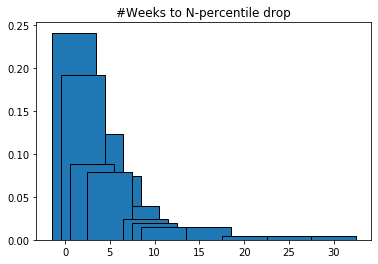

In [14]:
labels, values = zip(*Counter(l).items())
width = 5
plt.bar(labels, values/np.sum(values), width ,linewidth=1, edgecolor='black');
plt.title("#Weeks to N-percentile drop");

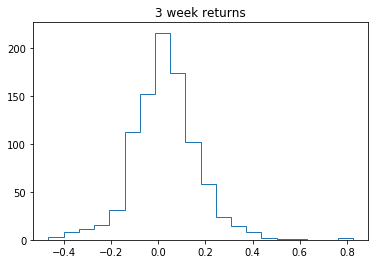

In [15]:
N=3
ret= (spy.adj_close/spy.adj_close.shift(N)-1).dropna()
plt.hist(ret, bins=20, histtype='step')
plt.title('{} week returns'.format(N));

In [16]:
ret.describe()

count    934.000000
mean       0.029153
std        0.140734
min       -0.466424
25%       -0.048982
50%        0.027314
75%        0.102234
max        0.824848
Name: adj_close, dtype: float64

### STD

In [17]:
get_percentile(spy.adj_close.rolling(3).apply(np.std, raw=False))

(83.96, 4.510759975387259)

In [18]:
get_percentile(spy.adj_close.rolling(4).apply(np.std, raw=False),t='val',val=90)

8.49649812175846

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


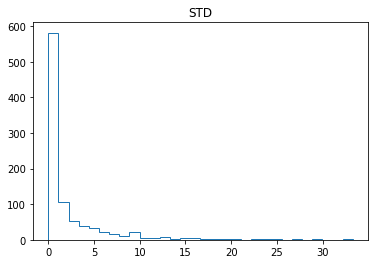

In [19]:
plt.hist(spy.adj_close.rolling(3
                              ).apply(np.std, raw=False), bins=30, histtype='step');
plt.title("STD");

### Sharpe Ratio

In [20]:
N=3
ret= (spy.adj_close/spy.adj_close.shift(N)-1).dropna()
std=spy.adj_close.rolling(N).apply(np.std, raw=False)
ret/std

0       0.000902
1       0.028705
2       0.006958
3       0.006832
4       0.020168
         ...    
932   -12.882723
933    -1.408208
934          NaN
935          NaN
936          NaN
Name: adj_close, Length: 937, dtype: float64

### STO

In [21]:
d={'function': 'STOCH','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker,'interval':'weekly','fastkperiod':16 }
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

In [22]:
slowk=[]
slowd=[]
for key, val in response.json()['Technical Analysis: STOCH'].items():
    slowk.append(float(val['SlowK']))
    slowd.append(float(val['SlowD']))

sto=pd.DataFrame({'Date':list(response.json()['Technical Analysis: STOCH'].keys()),
                 'k':slowk,
                  'd':slowd
                 })
sto=sto.astype({'Date': 'datetime64'})
sto['sto_diff']=sto['k']-sto['d']

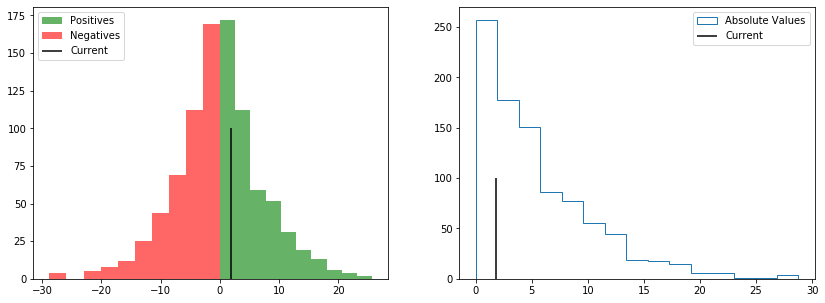

In [23]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(sto.sto_diff[sto.sto_diff>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
ax[0].hist(sto.sto_diff[sto.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
ax[0].vlines(sto.sto_diff[1],0,100 ,label='Current', color='black')
ax[0].legend(loc='upper left');

ax[1].hist(np.abs(sto.sto_diff), bins=15, histtype='step', label='Absolute Values');
ax[1].vlines(np.abs(sto.sto_diff[1]),0,100 ,label='Current')
ax[1].legend();

In [24]:
sto=sto.sort_values(by='Date')

In [25]:
get_percentile(sto.sto_diff)

(50.87, 0.3037000000000063)

In [26]:
get_percentile(sto.sto_diff, t='val', val=15)

-6.8901100000000035

In [27]:
# Diff probably helps more on the downside
get_percentile(sto.sto_diff[sto.sto_diff>=0],t='val',val=90)

12.640710000000011

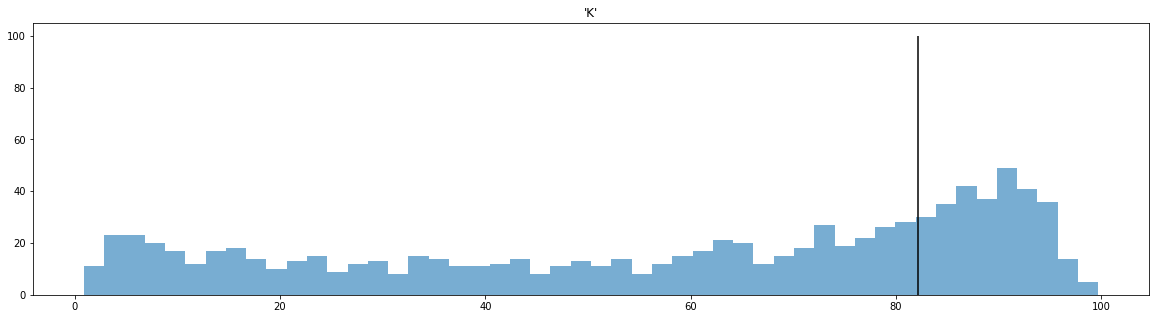

In [28]:
plt.figure(figsize=(20,5))
plt.title("'K'")
plt.vlines(sto.k[1],0,100)
plt.hist(sto.k, bins=50, alpha=0.6);


In [29]:
N=3
k_change=(sto.sort_values(by='Date').k/sto.sort_values(by='Date').k.shift(N)-1).dropna()

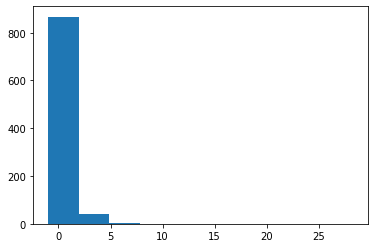

In [30]:
plt.hist(k_change);

In [31]:
get_percentile(k_change)

(59.56, 0.07378319807888789)

In [32]:
spy=spy.merge(sto,left_on='Date',right_on='Date',how='left')

In [33]:
spy['future_ret']=spy.adj_close.shift(-2)/spy.adj_close-1

In [34]:
vals=[[],[],[]]
upper_cut==5
lower_cut=-11
for index, row in spy.dropna().iterrows():
    if row.sto_diff<=upper_cut and row.sto_diff>=lower_cut:
        vals[0].append(row.Date)
        vals[1].append(row.sto_diff)
        vals[2].append(row.future_ret)

NameError: name 'upper_cut' is not defined

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(17,5))
ax[0].scatter(vals[1],vals[2], alpha=0.75)
ax[0].hlines(0,lower_cut,upper_cut);

ax[1].hist(vals[2], bins=20);
ax[2].hist(np.array(vals[2])[np.asarray(vals[2])>=0], bins=int(len(vals[2])/2));

In [ ]:
np.sum([np.asarray(vals[2])>=-0.05])/len(vals[2]), len(vals[2])

### MACD

In [ ]:
#MACD & MACD/return diff slope

In [ ]:
macd=spy.adj_close.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()-spy.adj_close.ewm(span=26,min_periods=0,adjust=True,ignore_na=True).mean()
signal=macd.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()
macd_hist=macd-signal

In [ ]:
spy['macd']=macd
spy['macd_hist']=macd_hist

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(macd_hist[macd_hist>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
ax[0].hist(sto.sto_diff[sto.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
ax[0].vlines(sto.sto_diff[1],0,100 ,label='Current', color='black')
ax[0].legend(loc='upper left');

ax[1].hist(np.abs(sto.sto_diff), bins=15, histtype='step', label='Absolute Values');
ax[1].vlines(np.abs(sto.sto_diff[1]),0,100 ,label='Current')
ax[1].legend();

In [ ]:
get_percentile(macd_hist)

### 20/50

In [ ]:
spy

In [ ]:
spy.adj_close.rolling(20).apply(np.mean, raw=False)